### Import Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math
import collections
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.metrics import mean_squared_error, mean_absolute_error


import category_encoders as ce

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


import xgboost
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

from sklearn.compose import TransformedTargetRegressor

### Import drive, dataset, helper functions

In [18]:
import configparser
import os
from pathlib import Path

path_to_AI_ML_folder = Path(os.getcwd()).parents[1]
#Read config.ini file
config_obj = configparser.ConfigParser()
config_obj.read(str(path_to_AI_ML_folder)+"\configfile.ini")
regression_paths = config_obj["regression_paths"]

In [19]:
print(regression_paths["car_price_dataset_path"])

c:\Users\rayst\OneDrive - AFour Technologies Pvt. Ltd\From G Suite Drive\Data Analytics\AI ML\Regression\Car price prediction\car_prices.csv.zip


In [20]:
import zipfile
import os
directory_to_extract_to=os.getcwd()
path_to_zip_file = regression_paths["car_price_dataset_path"]
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [4]:
cp -r /content/drive/MyDrive/"Data Analytics"/"AI ML"/Helper_Functions /content

cp: cannot open '/content/drive/MyDrive/Data Analytics/AI ML/Helper_Functions/README.md.gdoc' for reading: Operation not supported


In [28]:
from Helper_Functions import common_utils

ImportError: attempted relative import with no known parent package

### Read dataset

In [6]:
df = pd.read_csv("car_prices.csv", on_bad_lines='skip')
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [7]:
common_utils.get_dataset_info(df)

Head:
   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca        4.5    1331.0   gray    black   
3  yv1612tb4f1310987    ca        4.1   14282.0  white    black   
4  wba6b2c57ed129731    ca        4.3    2641.0   gray    black   

                                   seller    mmr  sellingprice  \
0                 kia motors america, inc  20500         21500   
1                 kia motors ame

In [8]:
# Delete columns : 'vin'
# We are dropping this column, because it just contains ID for the car, and has no importance in predictions
df = df.drop(columns = ['vin'])

### **Data Insights**

#### Extracting Categorical and Numerical columns from data

In [20]:
categorical_columns = []
numerical_columns = []

for x in df.columns:
  if df[x].dtypes == 'O':
    categorical_columns.append(x)
  else:
    if df[x].nunique()>20:
      numerical_columns.append(x)

In [21]:
categorical_columns

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'state',
 'color',
 'interior',
 'seller',
 'saledate']

In [22]:
numerical_columns

['year', 'condition', 'odometer', 'mmr', 'sellingprice']

#### Value counts in categorical columns

To get a trend of different categories in categorical columns

In [9]:
df['make'].value_counts()

Ford          93554
Chevrolet     60197
Nissan        53946
Toyota        39871
Dodge         30710
              ...  
airstream         1
ford tk           1
chev truck        1
hyundai tk        1
Lotus             1
Name: make, Length: 96, dtype: int64

In [10]:
df['model'].value_counts()

Altima        19349
F-150         14479
Fusion        12946
Camry         12545
Escape        11861
              ...  
rrs               1
golf              1
g500              1
tahoe             1
458 Italia        1
Name: model, Length: 973, dtype: int64

In [11]:
df['trim'].value_counts()

Base                 55817
SE                   43648
LX                   20757
Limited              18356
LT                   16915
                     ...  
xls                      1
4x2 reg silverado        1
awd v8 limited           1
4x2 v6 limited           1
Power Wagon              1
Name: trim, Length: 1975, dtype: int64

In [12]:
df['body'].value_counts()

Sedan          199437
SUV            119292
sedan           41906
suv             24552
Hatchback       21380
                ...  
g37 coupe           1
cab plus 4          1
CTS-V Wagon         1
Ram Van             1
cts wagon           1
Name: body, Length: 86, dtype: int64

In [13]:
df['transmission'].value_counts()

automatic    475914
manual        17544
Name: transmission, dtype: int64

In [14]:
df['state'].value_counts()

fl    82945
ca    73148
pa    53907
tx    45913
ga    34750
nj    27784
il    23486
nc    21845
oh    21575
tn    20895
mo    16013
mi    15511
nv    12685
va    12027
md    11158
wi     9851
mn     9429
az     8741
co     7775
wa     7416
ma     6729
ny     5699
in     4325
sc     4251
ne     4013
on     3442
pr     2725
la     2191
ms     1851
ut     1836
qc     1245
hi     1237
or     1155
ab      928
nm      171
ok       72
ns       61
al       26
Name: state, dtype: int64

In [15]:
df['color'].value_counts()

black        110970
white        106673
silver        83389
gray          82857
blue          51139
red           43569
—             24685
green         11382
gold          11342
beige          9222
burgundy       8972
brown          6717
orange         2078
purple         1561
off-white      1449
yellow         1285
charcoal        479
turquoise       236
pink             42
lime             15
Name: color, dtype: int64

In [16]:
df['interior'].value_counts()

black        244325
gray         178578
beige         59758
tan           44093
—             17076
brown          8640
red            1359
blue           1138
silver         1099
off-white       480
purple          339
gold            324
white           252
green           245
burgundy        191
orange          145
yellow           20
Name: interior, dtype: int64

In [17]:
df['seller'].value_counts()

nissan-infiniti lt                  19693
ford motor credit company,llc       19162
the hertz corporation               18299
santander consumer                  15285
avis corporation                    12540
                                    ...  
financeco of kansas                     1
r t m motors                            1
navigant credit union                   1
columbus preowned auto sales llc        1
i -5 uhlmann rv                         1
Name: seller, Length: 14264, dtype: int64

In [18]:
df['saledate'].value_counts()

Tue Feb 10 2015 01:30:00 GMT-0800 (PST)    5334
Tue Feb 17 2015 01:30:00 GMT-0800 (PST)    5016
Tue Jan 27 2015 01:30:00 GMT-0800 (PST)    4902
Tue Jan 20 2015 01:30:00 GMT-0800 (PST)    4731
Tue Mar 03 2015 01:30:00 GMT-0800 (PST)    4653
                                           ... 
Wed Apr 15 2015 08:05:00 GMT-0700 (PDT)       1
Wed May 13 2015 05:05:00 GMT-0700 (PDT)       1
Tue Feb 24 2015 11:20:00 GMT-0800 (PST)       1
Fri Jul 03 2015 06:35:00 GMT-0700 (PDT)       1
Wed Jul 08 2015 09:45:00 GMT-0700 (PDT)       1
Name: saledate, Length: 3745, dtype: int64

#### Boxplots for numerical columns

To see a trend of outliers in numerical columns

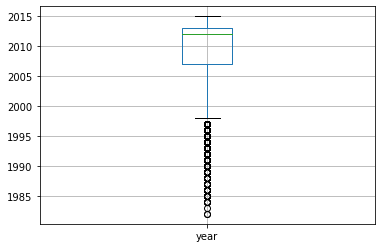

In [23]:
common_utils.plot_boxplot(df, ['year'])

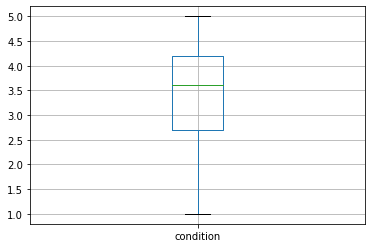

In [24]:
common_utils.plot_boxplot(df, ['condition'])

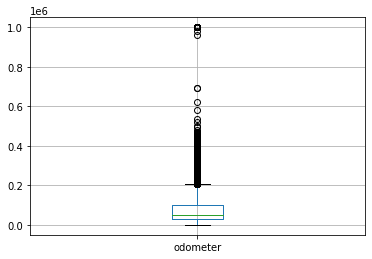

In [25]:
common_utils.plot_boxplot(df, ['odometer'])

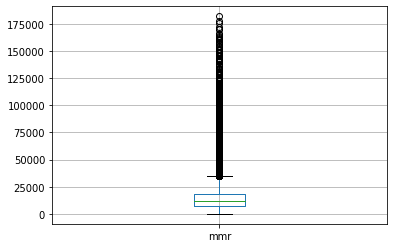

In [26]:
common_utils.plot_boxplot(df, ['mmr'])

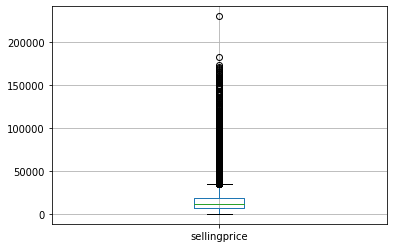

In [27]:
common_utils.plot_boxplot(df, ['sellingprice'])

#### Missing values in data

In [19]:
common_utils.get_count_and_percentage_missing_values(df)

              count  % null
year              0     0.0
make          10301     1.8
model         10399     1.9
trim          10651     1.9
body          13195     2.4
transmission  65353    11.7
state             0     0.0
condition     11794     2.1
odometer         94     0.0
color           749     0.1
interior        749     0.1
seller            0     0.0
mmr               0     0.0
sellingprice      0     0.0
saledate          0     0.0


#### Heatmap
Gives the correlation between the target and features

                  year  condition  odometer       mmr  sellingprice
year          1.000000   0.551282 -0.772720  0.596623      0.586488
condition     0.551282   1.000000 -0.538874  0.485050      0.538788
odometer     -0.772720  -0.538874  1.000000 -0.588107     -0.582405
mmr           0.596623   0.485050 -0.588107  1.000000      0.983634
sellingprice  0.586488   0.538788 -0.582405  0.983634      1.000000


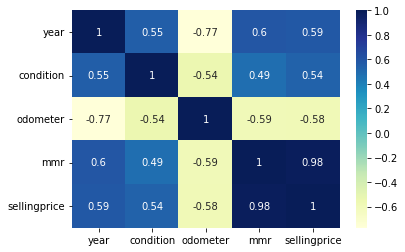

In [31]:
common_utils.plot_heatmap(df)

#### Using select k best feature to get which columns to use

In [35]:
df_temp = df

In [39]:
df_temp = fill_missing_values(df_temp)

In [40]:
x_num = df_temp[['year', 'condition', 'odometer', 'mmr']]
y = df_temp['sellingprice']

In [41]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
selector1 = SelectKBest(score_func = f_regression, k = 3)
selector1.fit(x_num, y)

SelectKBest(k=3, score_func=<function f_regression at 0x7f955bf443b0>)

In [42]:
cols = selector1.get_support(indices=True)

In [43]:
cols

array([0, 2, 3])

No need to drop any numeric column

### **Data preprocessing**
Creating functions that can directly be called when making the ML model

#### Duplicates

In [28]:
def remove_duplicates(df):
  return df.drop_duplicates()

#### Handle missing and null values

In [29]:
def fill_missing_values(df):

  for x in categorical_columns:
   df[x].fillna(df[x].mode()[0],inplace=True)
  df['condition'].fillna(df['condition'].mean(),inplace=True)
  df = df[df['odometer'].notna()]

  return df

#### Removing outliers

In [44]:
def remove_outlier(df, col_name):
  q1 = df[col_name].quantile(0.25)
  q3 = df[col_name].quantile(0.75)
  iqr = q3-q1 #Interquartile range
  fence_low  = q1-1.5*iqr
  fence_high = q3+1.5*iqr
  df_out = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]
  return df_out

#### Binary Encoding

In [45]:
def apply_encoding(df, columns, be=True):
  encoder= ce.BinaryEncoder(cols=columns,return_df=True)
  df=encoder.fit_transform(df) 
  return df

### Download df as csv

In [46]:
df1 = fill_missing_values(df)

In [47]:
df1.to_csv('car_prices_pred.csv', index=False)

### **Random Forest**

In [48]:
# Using functions to preprocess data
df_new = remove_duplicates(df)
df_new = fill_missing_values(df_new)
common_utils.get_count_and_percentage_missing_values(df_new)
df_new = apply_encoding(df_new,categorical_columns)
df_new.head()

              count  % null
year              0     0.0
make              0     0.0
model             0     0.0
trim              0     0.0
body              0     0.0
transmission      0     0.0
state             0     0.0
condition         0     0.0
odometer          0     0.0
color             0     0.0
interior          0     0.0
seller            0     0.0
mmr               0     0.0
sellingprice      0     0.0
saledate          0     0.0


,year,make_0,make_1,make_2,make_3,make_4,make_5,make_6,model_0,model_1,...,saledate_2,saledate_3,saledate_4,saledate_5,saledate_6,saledate_7,saledate_8,saledate_9,saledate_10,saledate_11
0,2015,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2015,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2014,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2015,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1
4,2014,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [49]:
# Data splitting into train and test 70:30 ratio
df_new_train, df_new_test = train_test_split(df_new, test_size = .30, random_state=1)

In [50]:
print(df_new_train.shape, df_new_test.shape)

(391101, 84) (167616, 84)


Removing outliers from numerical columns

In [51]:
df_new_train = remove_outlier(df_new_train, 'mmr')
df_new_test = remove_outlier(df_new_test, 'mmr')

In [52]:
df_new_train = remove_outlier(df_new_train, 'odometer')
df_new_test = remove_outlier(df_new_test, 'odometer')

In [53]:
df_new_train = remove_outlier(df_new_train, 'year')
df_new_test = remove_outlier(df_new_test, 'year')

In [54]:
print(df_new_train.shape, df_new_test.shape)

(364355, 84) (156372, 84)


x and y split from train and test each

In [55]:
x_train = df_new_train.copy()
x_train = x_train.drop(columns = ['sellingprice'])
y_train = df_new_train['sellingprice']

In [56]:
x_test = df_new_test.copy()
x_test = x_test.drop(columns = ['sellingprice'])
y_test = df_new_test['sellingprice']

Checking which columns to normalize and which to scale

In [57]:
def preprocess_numeric_column_data(data):
  columns = data.columns
  for i in columns:
    if data.dtypes[i] == np.object:
      print("Cannot process object data")
      return

  ## if skew is 0.5 and -0.5 i.e its normal distribution and use scaler else normalise
  scale_list = []
  normalise_list = []
  data_skew = data.skew()

  for i in columns:
    if data_skew[i] >= -0.5 and data_skew[i] <= 0.5:
      scale_list.append(i)
    else:
      normalise_list.append(i)
  return (scale_list, normalise_list)

In [60]:
scale_list, normalise_list = preprocess_numeric_column_data(x_train[['year', 'condition', 'odometer', 'mmr']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [61]:
scale_list

['condition']

In [62]:
normalise_list

['year', 'odometer', 'mmr']

In [63]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(x_train[scale_list])
x_train[scale_list] = standard_scaler.transform(x_train[scale_list])
x_test[scale_list] = standard_scaler.transform(x_test[scale_list])

In [64]:
normal_scaler = preprocessing.MinMaxScaler()
normal_scaler.fit(x_train[normalise_list])
x_train[normalise_list] = normal_scaler.transform(x_train[normalise_list])
x_test[normalise_list] = normal_scaler.transform(x_test[normalise_list])

In [65]:
pickle.dump(standard_scaler, open("standard_scaler.pkl", "wb"))

In [66]:
pickle.dump(normal_scaler, open("normal_scaler.pkl", "wb"))

In [68]:
# define model
model_randomforest = RandomForestRegressor(n_estimators=100, random_state=0)
model_randomforest.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

In [69]:
file_name = "model_randomforest.pkl"

In [70]:
pickle.dump(model_randomforest, open(file_name, "wb"))

In [71]:
y_hat = model_randomforest.predict(x_test)

In [72]:
y_test_arr = y_test.to_numpy()

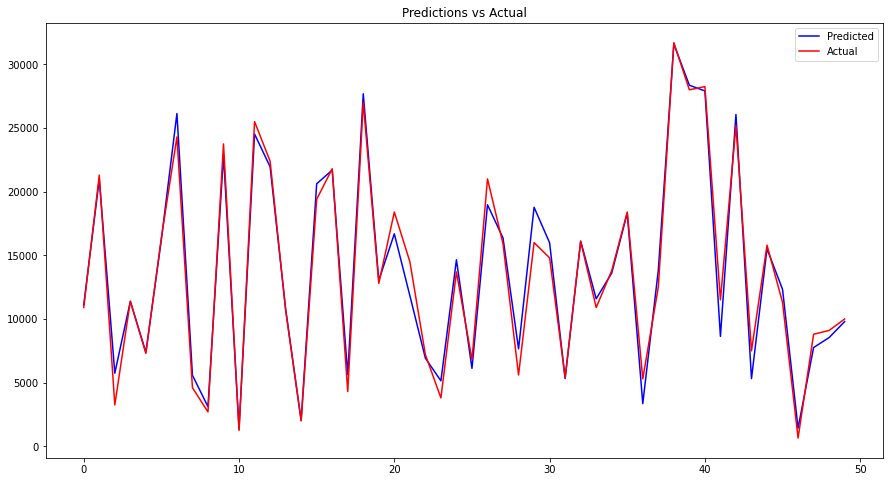

In [73]:
plt.figure(figsize=(15, 8))
plt.plot(y_hat[0:50], label='Predicted', color="blue")
plt.plot(y_test_arr[0:50], label='Actual', color="red")
plt.title("Predictions vs Actual")
plt.legend()

In [74]:
mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test)) # Median Absolute Percentage Error
acc = 1-mdape
print("Median Absolute Percentage Error: ",mdape)
print("Accuracy: ", acc)

Median Absolute Percentage Error:  0.05500035714285715
Accuracy:  0.9449996428571429


### **Decision Tree**

In [75]:
# define model
model_decisiontree = DecisionTreeRegressor()
model_decisiontree.fit(x_train, y_train)

DecisionTreeRegressor()

In [76]:
file_name = "model_decisiontree.pkl"

In [77]:
pickle.dump(model_decisiontree, open(file_name, "wb"))

In [78]:
y_hat = model_decisiontree.predict(x_test)

In [79]:
y_test_arr = y_test.to_numpy()

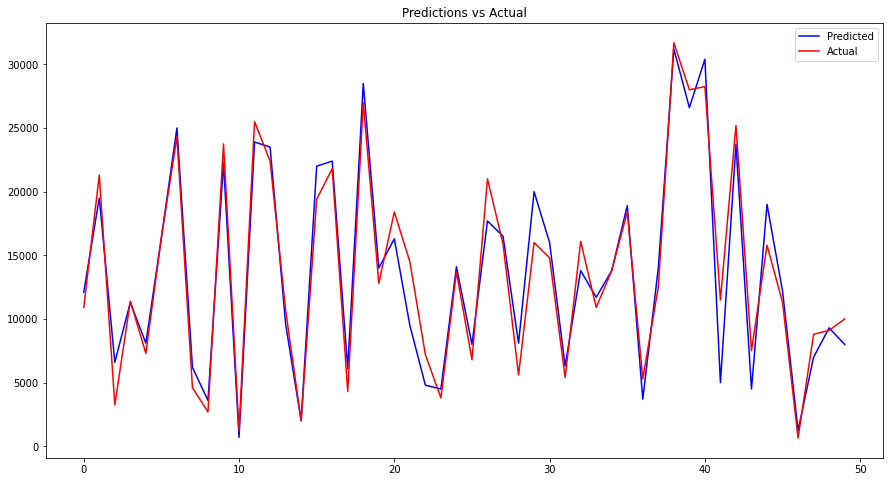

In [80]:
plt.figure(figsize=(15, 8))
plt.plot(y_hat[0:50], label='Predicted', color="blue")
plt.plot(y_test_arr[0:50], label='Actual', color="red")
plt.title("Predictions vs Actual")
plt.legend()

In [81]:
mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
acc = 1-mdape
print("Median Absolute Percentage Error: ",mdape)
print("Accuracy: ", acc)

Median Absolute Percentage Error:  0.08399218750000001
Accuracy:  0.9160078125


### **XGBoost**

In [82]:
model_xgb = XGBRegressor(learning_rate = 0.01, n_estimators = 1000, max_depth = 10)
model_xgb.fit(x_train, y_train)

[06:29:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000)

In [83]:
y_hat = model_xgb.predict(x_test)

In [84]:
file_name = "model_xgboost.pkl"

In [85]:
pickle.dump(model_xgb, open(file_name, "wb"))

In [86]:
y_test_arr = y_test.to_numpy()

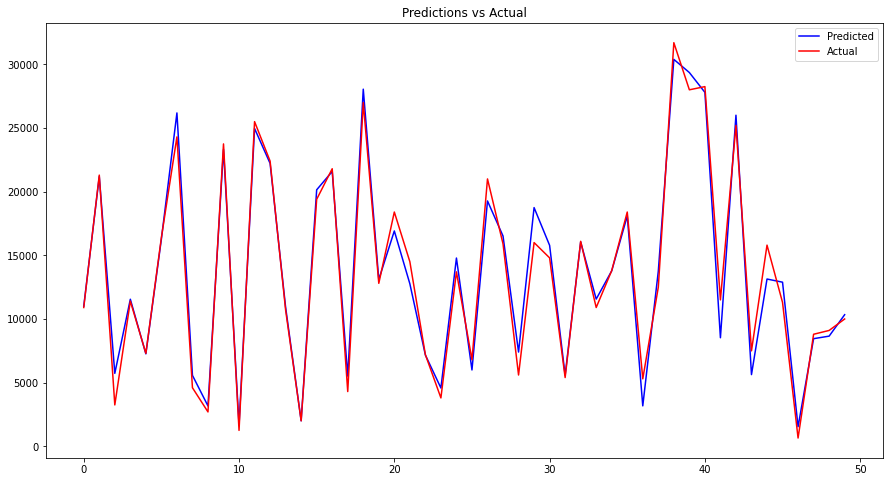

In [87]:
plt.figure(figsize=(15, 8))
plt.plot(y_hat[0:50], label='Predicted', color="blue")
plt.plot(y_test_arr[0:50], label='Actual', color="red")
plt.title("Predictions vs Actual")
plt.legend()

In [88]:
mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
acc = 1-mdape
print("Median Absolute Percentage Error: ",mdape)
print("Accuracy: ", acc)

Median Absolute Percentage Error:  0.05178013527518271
Accuracy:  0.9482198647248173


### Sampling

Creating a sample of 10,000 rows to run with kfold and gridsearchcv.
Running for 50,00,000+ rows is computationally expensive

In [89]:
df_sample = df.sample(n = 10000)

In [90]:
df_sample.shape

(10000, 15)

### **RandomForest with kfold**

In [91]:
df_new_sampled = remove_duplicates(df_sample)
df_new_sampled = fill_missing_values(df_new_sampled)
common_utils.get_count_and_percentage_missing_values(df_new_sampled)
df_new_sampled = apply_encoding(df_new_sampled,categorical_columns)
df_new_sampled.head()

              count  % null
year              0     0.0
make              0     0.0
model             0     0.0
trim              0     0.0
body              0     0.0
transmission      0     0.0
state             0     0.0
condition         0     0.0
odometer          0     0.0
color             0     0.0
interior          0     0.0
seller            0     0.0
mmr               0     0.0
sellingprice      0     0.0
saledate          0     0.0


,year,make_0,make_1,make_2,make_3,make_4,make_5,make_6,model_0,model_1,...,saledate_1,saledate_2,saledate_3,saledate_4,saledate_5,saledate_6,saledate_7,saledate_8,saledate_9,saledate_10
29723,1997,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
365463,2011,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
438803,2014,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1
219613,2013,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
50117,2014,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1


In [92]:
kf = KFold(n_splits=10,random_state=1,shuffle=True)
i = 1
for train_index, test_index in kf.split(df_new_sampled):
  print('\n{} of kfold {}'.format(i,kf.n_splits))

  df_new_train, df_new_test = df_new.iloc[train_index], df_new.iloc[test_index]

  df_new_train = remove_outlier(df_new_train, 'mmr')
  df_new_test = remove_outlier(df_new_test, 'mmr')
  df_new_train = remove_outlier(df_new_train, 'odometer')
  df_new_test = remove_outlier(df_new_test, 'odometer')
  df_new_train = remove_outlier(df_new_train, 'year')
  df_new_test = remove_outlier(df_new_test, 'year')

  x_train = df_new_train.copy()
  x_train = x_train.drop(columns = ['sellingprice'])
  y_train = df_new_train['sellingprice']

  x_test = df_new_test.copy()
  x_test = x_test.drop(columns = ['sellingprice'])
  y_test = df_new_test['sellingprice']

  model_onehot = XGBRegressor(learning_rate = 0.01, n_estimators = 1000, max_depth = 10)
  model_onehot.fit(x_train, y_train)
  # print (model.best_params_)
  y_hat = model_onehot.predict(x_test)
  mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
  acc = 1-mdape
  print("Median Absolute Percentage Error: ",mdape)
  print("Accuracy: ", acc)
  i+=1


1 of kfold 10
[07:21:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.06134858630952381
Accuracy:  0.9386514136904762

2 of kfold 10
[07:22:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.06742210210755814
Accuracy:  0.9325778978924418

3 of kfold 10
[07:23:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.06557178844105113
Accuracy:  0.9344282115589488

4 of kfold 10
[07:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Median Absolute Percentage Error:  0.06281267582935653
Accuracy:  0.9371873241706434

5 of kfold 10
[07:25:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linea

### **XGBoost with kfold and gridsearchcv**

In [93]:
kf = KFold(n_splits=10,random_state=1,shuffle=True)
i = 1
for train_index, test_index in kf.split(df_new_sampled):
  print('\n{} of kfold {}'.format(i,kf.n_splits))

  df_new_train, df_new_test = df_new.iloc[train_index], df_new.iloc[test_index]

  df_new_train = remove_outlier(df_new_train, 'mmr')
  df_new_test = remove_outlier(df_new_test, 'mmr')
  df_new_train = remove_outlier(df_new_train, 'odometer')
  df_new_test = remove_outlier(df_new_test, 'odometer')
  df_new_train = remove_outlier(df_new_train, 'year')
  df_new_test = remove_outlier(df_new_test, 'year')

  x_train = df_new_train.copy()
  x_train = x_train.drop(columns = ['sellingprice'])
  y_train = df_new_train['sellingprice']

  x_test = df_new_test.copy()
  x_test = x_test.drop(columns = ['sellingprice'])
  y_test = df_new_test['sellingprice']

  xgb1 = XGBRegressor()
  parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
                'learning_rate': [0.01, 0.05, 0.1, 0.5], #so called `eta` value
                'max_depth': [5, 6, 7, 8],
                'min_child_weight': [4],
                'silent': [1],
                'subsample': [0.7],
                'colsample_bytree': [0.7],
                'n_estimators': [500]}

  xgb_grid = GridSearchCV(xgb1, parameters, cv = 2, n_jobs = 5, verbose=True)

  xgb_grid.fit(x_train, y_train)
  y_hat = xgb_grid.predict(x_test)
  mdape = np.median(np.abs(y_hat - y_test)/np.abs(y_test))
  acc = 1-mdape
  print("Median Absolute Percentage Error: ",mdape)
  print("Accuracy: ", acc)
  i+=1
  print("Best parameters: ", xgb_grid.best_params_)


1 of kfold 10
Fitting 2 folds for each of 16 candidates, totalling 32 fits
Median Absolute Percentage Error:  0.06390721055327869
Accuracy:  0.9360927894467213
Best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'silent': 1, 'subsample': 0.7}

2 of kfold 10
Fitting 2 folds for each of 16 candidates, totalling 32 fits
Median Absolute Percentage Error:  0.06706898082386363
Accuracy:  0.9329310191761364
Best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'silent': 1, 'subsample': 0.7}

3 of kfold 10
Fitting 2 folds for each of 16 candidates, totalling 32 fits
Median Absolute Percentage Error:  0.0697303214905754
Accuracy:  0.9302696785094247
Best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'silent': 1, 'subsample': 0.7}

4

### Script to run all regressors

In [ ]:
regressors = ['XGBRegressor', 'RandomForestRegressor', 'DecisionTreeRegressor', 'ExtraTreesRegressor', 'AdaBoostRegressor']

for reg in regressors:
  if reg == 'XGBRegressor':
    regressor = XGBRegressor()
  if reg == 'RandomForestRegressor':
    regressor = RandomForestRegressor(n_estimators=100, random_state=0)
  if reg == 'DecisionTreeRegressor':
    regressor = DecisionTreeRegressor()
  if reg == 'ExtraTreesRegressor':
    regressor = ExtraTreesRegressor()
  if reg == 'AdaBoostRegressor':
    regressor = AdaBoostRegressor()

  regressor = TransformedTargetRegressor(regressor=regressor, transformer=MinMaxScaler())
  regressor.fit(x_train, y_train)
  y_pred = regressor.predict(x_test)

  plt.figure(figsize=(15, 8))
  plt.plot(y_pred[0:50], label='Predicted', color="blue")
  plt.plot(y_test_arr[0:50], label='Actual', color="red")
  plt.title(reg)
  plt.legend()

  print("\n")
  print("Accuracy for ", reg)
  acc = 1 - np.median(np.abs(y_pred - y_test)/np.abs(y_test))
  print(acc)